<a href="https://colab.research.google.com/github/OlliMakarova/-/blob/main/%D0%94%D0%B8%D0%BF%D0%BB%D0%BE%D0%BC%D0%BD%D0%B0%D1%8F_%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%B0_%D0%9E%D1%86%D0%B5%D0%BD%D0%BA%D0%B0_%22%D0%B5%D1%81%D1%82%D0%B5%D1%81%D1%82%D0%B2%D0%B5%D0%BD%D0%BD%D0%BE%D1%81%D1%82%D0%B8%22_%D1%82%D0%B5%D0%BA%D1%81%D1%82%D0%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Дипломная работа

## Определение "естественности" текста: написан текст человеком или машиной

Для создания сети буду использовать BagOfWords

Примеры текста, сгенерированные ИИ формировались буду брать здесь: https://chatbot.theb.ai/#/chat/1002

В качестве примеров "человеческого" текста буду использовать отрывки из литературных произведений и статей из интернета, заведомо написанных человекм.


## Библиотеки, константы, функции

In [ ]:
#@title Импорт библиотек

from typing import Any, List, Tuple
from google.colab import files
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
%matplotlib inline

from tensorflow.keras import utils
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation
from tensorflow.keras.preprocessing.text import Tokenizer, tokenizer_from_json
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from google.colab import drive
import time

import zipfile
import shutil
import pickle
from ipywidgets import Textarea, Button, Layout, HTML


In [ ]:
# Подключаем диск для загрузки текстов и сохранения модели
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#@title Константы

PROJECT_PATH = '/content/drive/MyDrive/diplom/'

# ID модели для сохранения и загрузки
SAMPLE_ID = '1'

# Максимальное количество слов, учитываемое при обучении текстов
MAX_WORDS_COUNT = 20000

# Количество слов в "BAG"
WORDS_IN_BAG = 200

# Сдвигаемся на это количество слов, пробегая по начальным тестам и выбираем по WORDS_IN_BAG слов
WORDS_SHIFT = 50

# Файл для сохранения токенайзера
TOKENIZER_DUMP_FILE = f'{PROJECT_PATH}tokenizer.pickle'


In [ ]:
from weakref import finalize
#@title Функции работы с файлами: сохранение и загрузки модели, чтение текстов

def move_to_zip(file_2_zip: str) -> str | None:
  outpath = f'{file_2_zip}.zip'
  try:
    with zipfile.ZipFile(outpath, 'w', compression=zipfile.ZIP_DEFLATED) as zf:
        zf.write(file_2_zip, os.path.basename(file_2_zip))
    os.remove(file_2_zip)
    return outpath
  except:
    print("Error move_to_zip file : ", file_2_zip)
    return None


def un_zip_model(zip_file):
  shutil.unpack_archive(zip_file, PROJECT_PATH)


def get_model_path(sample_id = '0') -> str:
  return f'{PROJECT_PATH}model_{sample_id}'


def model_save(model, sample_id = '0'):
  model_path_ext = get_model_path(sample_id) + '.h5'
  model.save(model_path_ext)
  zip_file = move_to_zip(model_path_ext)
  print(f'Модель упакована и сохранена в {zip_file}')


def save_tokenizer(tokenizer):
  with open(TOKENIZER_DUMP_FILE, 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
  print(f"Токенайзер сохранен в файл '{TOKENIZER_DUMP_FILE}'")


def load_tokenizer():
  with open(TOKENIZER_DUMP_FILE, 'rb') as handle:
    tokenizer = pickle.load(handle)
  print(f"Загружен токенайзер из файла '{TOKENIZER_DUMP_FILE}'")
  return tokenizer


def model_restore(sample_id = '0', compile = False):
  model_path_name = get_model_path(sample_id)
  model_path_ext = f'{model_path_name}.h5'
  zip_file = f'{model_path_ext}.zip'
  # Извлекаем файл модели из архива
  un_zip_model(zip_file)
  # Загружаем модель в память и компилируем, если нужно
  model = load_model(model_path_ext, compile)
  # Файл модели большой и он далее не требуется, удаляем его
  os.remove(model_path_ext)
  print(f'Загружена модель из файла {zip_file}')
  return model


def readText(fileName: str) -> str:
  """
  Читает указанный файл с диска и возвращет его текст.
  """
  f = open(fileName, 'r')
  return f.read()


In [ ]:
from numpy.typing import NDArray
#@title Функции подготовки данных для обучения и отображения результатов

def normalize_space(text: str) -> str:
  """
  Заменяет все последовательности пробельныех символов (пробелы, переводы строки и каретки, табуляции) на один пробел
  """
  return re.sub(r'(\xa0|\s)+', ' ', text).strip()


def get_tokenizer(texts: str, maxWordsCount = MAX_WORDS_COUNT):
  """
  Возвращает токенайзер.
  Функция используется при обучении и при использовании модели.
  """
  tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\ufeff', lower=True, split=' ', oov_token='unknown', char_level=False)
  # Создаем словарь частотности
  tokenizer.fit_on_texts([texts])
  return tokenizer


def split_to_bags_of_words(word_indexes_list: List[int], xLen: int, step: int, add_last_part = False) -> List[List[int]]:
  """
  Нарезаем массив word_indexes_list на кусочки длиной xLen, смещаясь на step
  """
  arrays_lists: List[List[int]] = [] # Объявляем переменную для векторов
  words_len = len(word_indexes_list)
  index = 0
  while (index + xLen <= words_len):
    arrays_lists.append(word_indexes_list[index:index + xLen]) # Формируем векторы длины xLen
    index += step
  if add_last_part:
    arrays_lists.append(word_indexes_list[index:index + xLen]) # Добавляем последнюю порцию, которая меньше xLen
  return arrays_lists


def load_texts_to_arrays(texts_directory: str = PROJECT_PATH) -> Tuple[NDArray[np.int_], NDArray[np.int_], NDArray[np.int_], NDArray[np.int_], NDArray[np.int_], NDArray[np.int_]]:
  """
  Загружает человеческие и машинные тексты из 2-х файлов.
  Нормализует тексты.
  Токенезирует весь объем текстов (человеческие и машинные)
  Переводит тексты в массивы индексов слов (с помощью токенайзера)
  Формирует два массива фрагментов длиной WORDS_IN_BAG со сдвигом WORDS_SHIFT (один массив из индекстов человеческих текстов, другой - из машинных)
  Разрезает каждый из массивов с помощью train_test_split(), примененную дважды, на обучающую, тестовую и проверочную выборки.
  При этом перемешивает фрагменты, чтобы они равномерно распределились между тремя типами выборок.
  Массивы обучающих объединяет, устанавливая в соответсвие признаки ЧЕЛОВЕК/МАШИНА (xTrain - yTrain)
  Аналогично поступает с тестовыми и проверочными выборками.
  Возвращает 3 пары массивов
  """

  # Загружаем человеческие тексты
  texts_machine = readText(texts_directory + 'texts_machine.txt')
  texts_human = readText(texts_directory + 'texts_human.txt')

  # Нормализуем тексты
  texts_machine = normalize_space(texts_machine)
  texts_human = normalize_space(texts_human)

  # Токенезируем весь объем текстов
  tokenizer = get_tokenizer(texts_human + texts_machine)

  # Сохраняем токенайзер в файл для использования на этапе проверки и тестирования в форме
  save_tokenizer(tokenizer)
  print("Словарный индекс: ", tokenizer.word_index)

  # Преобразовываем текст в последовательность индексов согласно словарю частотности
  machine_indexes_list: List[int] = tokenizer.texts_to_sequences([texts_machine])[0]
  human_indexes_list: List[int] = tokenizer.texts_to_sequences([texts_human])[0]

  # Разрезаем массивы индексов на кусочки длиной WORDS_IN_BAG со сдвигом WORDS_SHIFT
  machine_arrays_lists: List[List[int]] = split_to_bags_of_words(machine_indexes_list, WORDS_IN_BAG, WORDS_SHIFT)
  human_arrays_lists: List[List[int]] = split_to_bags_of_words(human_indexes_list, WORDS_IN_BAG, WORDS_SHIFT)

  # Отрезаем от каждого из массивов 20% на проверочную выборку. При этом перемешиваем фрагменты.
  machine_work_arrays_lists, machine_check_arrays_lists = train_test_split(machine_arrays_lists, test_size=0.20, random_state=42)
  human_work_arrays_lists, human_check_arrays_lists = train_test_split(human_arrays_lists, test_size=0.20, random_state=42)

  # Отрезаем от каждого из больших массивов (80% от начальной выборки) еще 20% на тестовую выборку. При этом перемешиваем фрагменты.
  machine_train_arrays_lists, machine_test_arrays_lists = train_test_split(machine_work_arrays_lists, test_size=0.20, random_state=42)
  human_train_arrays_lists, human_test_arrays_lists = train_test_split(human_work_arrays_lists, test_size=0.20, random_state=42)

  # Объединяем массивы обучающих выборок в одну и формируем массив признаков yTrain
  train_arrays_lists = machine_train_arrays_lists + human_train_arrays_lists
  xTrainBOW: NDArray[np.int_] = tokenizer.sequences_to_matrix(train_arrays_lists)
  yTrain: NDArray[np.int_] = np.asarray([[1, 0]] * len(machine_train_arrays_lists) + [[0, 1]] * len(human_train_arrays_lists))

  # Объединяем массивы тестовых выборок в одну и формируем массив признаков yTest
  test_arrays_lists = machine_test_arrays_lists + human_test_arrays_lists
  xTestBOW: NDArray[np.int_] = tokenizer.sequences_to_matrix(test_arrays_lists)
  yTest: NDArray[np.int_] = np.asarray([[1, 0]] * len(machine_test_arrays_lists) + [[0, 1]] * len(human_test_arrays_lists))

  # Объединяем массивы проверочных выборок в одну и формируем массив признаков yCheck
  check_arrays_lists = machine_check_arrays_lists + human_check_arrays_lists
  xCheckBOW: NDArray[np.int_] = tokenizer.sequences_to_matrix(check_arrays_lists)
  yCheck: NDArray[np.int_] = np.asarray([[1, 0]] * len(machine_check_arrays_lists) + [[0, 1]] * len(human_check_arrays_lists))

  return xTrainBOW, yTrain, xTestBOW, yTest, xCheckBOW, yCheck


def plotTrainResult(accuracy, val_accuracy):
  """
  Отображает результаты обучения модели
  """
  plt.figure(figsize=(14,7))
  plt.plot(accuracy, label='Доля верных ответов на обучающем наборе')
  plt.plot(val_accuracy, label='Доля верных ответов на тестовом наборе')
  plt.xlabel('Эпоха обучения')
  plt.ylabel('Доля верных ответов')
  plt.legend()
  plt.show()

## Обучение модели

In [ ]:
#@title Загрузка текстов

# Получаем 4 массива для обучения нейросетки и 2 - для проверки
xTrainBOW, yTrain, xTestBOW, yTest, xCheckBOW, yCheck = load_texts_to_arrays()

Токенайзер сохранен в файл '/content/drive/MyDrive/diplom/tokenizer.pickle'
Словарный индекс:  {'unknown': 1, 'и': 2, 'в': 3, 'на': 4, 'что': 5, 'не': 6, 'он': 7, 'с': 8, 'это': 9, 'но': 10, 'его': 11, 'как': 12, 'к': 13, 'она': 14, 'для': 15, 'а': 16, 'из': 17, 'они': 18, 'по': 19, 'о': 20, 'то': 21, 'все': 22, 'был': 23, 'чтобы': 24, 'я': 25, 'за': 26, 'ее': 27, 'когда': 28, 'очень': 29, 'может': 30, 'от': 31, 'у': 32, 'которые': 33, 'быть': 34, 'была': 35, 'или': 36, 'их': 37, 'так': 38, 'который': 39, 'только': 40, 'было': 41, 'жизни': 42, 'мы': 43, 'также': 44, 'могут': 45, 'однажды': 46, 'своей': 47, 'свою': 48, 'ему': 49, 'время': 50, 'того': 51, 'же': 52, 'если': 53, 'более': 54, 'были': 55, 'день': 56, 'со': 57, 'всегда': 58, 'том': 59, 'свои': 60, 'до': 61, 'людей': 62, 'еще': 63, 'своих': 64, 'этот': 65, 'можно': 66, 'люди': 67, 'после': 68, 'каждый': 69, 'ей': 70, 'даже': 71, 'человек': 72, 'жизнь': 73, 'себя': 74, 'есть': 75, 'свой': 76, 'уже': 77, 'где': 78, 'нам': 79, 'к

In [ ]:
print(xTrainBOW)
print(yTrain)

[[0. 1. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]]
[[1 0]
 [1 0]
 [1 0]
 ...
 [0 1]
 [0 1]
 [0 1]]


### Создание и обучение нейросети. Сохранение модели

Epoch 1/15
15/15 [==============================] - 3s 59ms/step - loss: 0.2060 - accuracy: 0.9372 - val_loss: 6.0044 - val_accuracy: 0.6807
Epoch 2/15
15/15 [==============================] - 1s 34ms/step - loss: 0.0628 - accuracy: 0.9828 - val_loss: 11.0585 - val_accuracy: 0.6053
Epoch 3/15
15/15 [==============================] - 1s 34ms/step - loss: 0.0057 - accuracy: 0.9972 - val_loss: 6.8819 - val_accuracy: 0.6364
Epoch 4/15
15/15 [==============================] - 1s 35ms/step - loss: 0.0020 - accuracy: 0.9994 - val_loss: 3.6945 - val_accuracy: 0.6984
Epoch 5/15
15/15 [==============================] - 1s 35ms/step - loss: 4.0064e-04 - accuracy: 1.0000 - val_loss: 1.8329 - val_accuracy: 0.7761
Epoch 6/15
15/15 [==============================] - 1s 35ms/step - loss: 1.4559e-04 - accuracy: 1.0000 - val_loss: 0.9437 - val_accuracy: 0.8581
Epoch 7/15
15/15 [==============================] - 1s 35ms/step - loss: 3.7955e-04 - accuracy: 1.0000 - val_loss: 0.4833 - val_accuracy: 0.8958


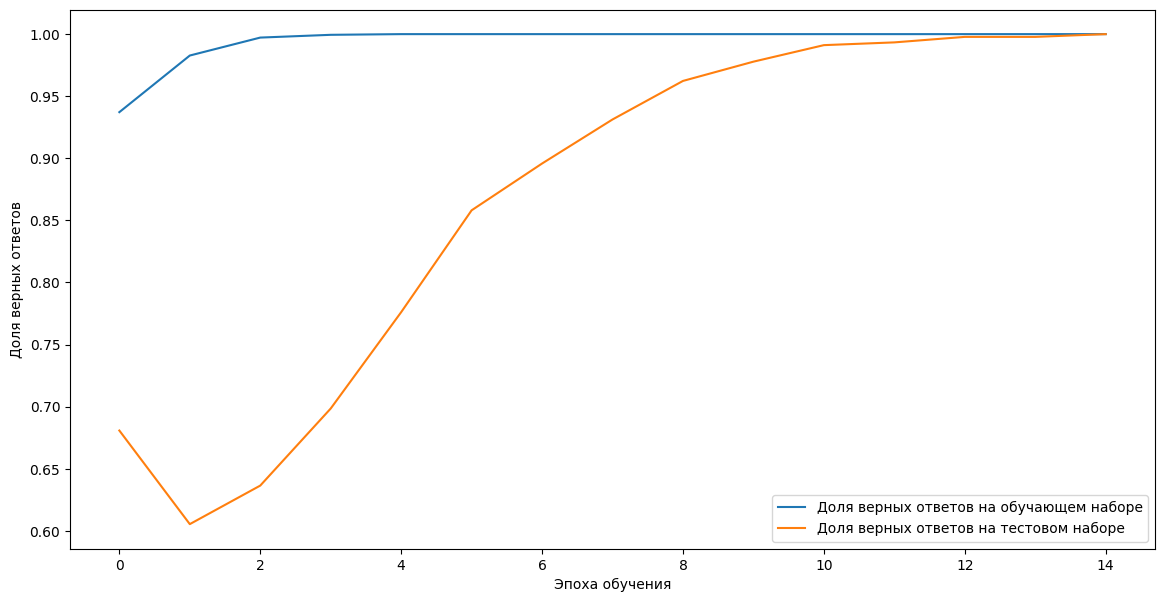

In [ ]:
# Создаём полносвязную сеть

model02 = Sequential()
model02.add(Dense(5000, input_dim=MAX_WORDS_COUNT, activation="relu"))
model02.add(Dropout(0.25))
model02.add(Dense(500, input_dim=MAX_WORDS_COUNT, activation="linear"))
model02.add(Dropout(0.25))
model02.add(BatchNormalization())
model02.add(Dense(2, activation='softmax'))

model02.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Обучаем сеть на выборке, сформированной по bag of words - xTrainBOW
history = model02.fit(
  xTrainBOW,
  yTrain,
  epochs=15,
  batch_size=128,
  validation_data=(xTestBOW, yTest)
)

plotTrainResult(history.history['accuracy'], history.history['val_accuracy'])

Epoch 1/8
15/15 [==============================] - 3s 57ms/step - loss: 1.7224e-05 - accuracy: 1.0000 - val_loss: 7.8671e-04 - val_accuracy: 1.0000
Epoch 2/8
15/15 [==============================] - 1s 35ms/step - loss: 1.7134e-05 - accuracy: 1.0000 - val_loss: 3.3762e-04 - val_accuracy: 1.0000
Epoch 3/8
15/15 [==============================] - 1s 35ms/step - loss: 1.9703e-05 - accuracy: 1.0000 - val_loss: 1.8707e-04 - val_accuracy: 1.0000
Epoch 4/8
15/15 [==============================] - 1s 35ms/step - loss: 0.0024 - accuracy: 0.9989 - val_loss: 9.3385e-05 - val_accuracy: 1.0000
Epoch 5/8
15/15 [==============================] - 1s 35ms/step - loss: 0.0102 - accuracy: 0.9983 - val_loss: 6.4677e-05 - val_accuracy: 1.0000
Epoch 6/8
15/15 [==============================] - 1s 36ms/step - loss: 1.7950e-05 - accuracy: 1.0000 - val_loss: 5.8108e-05 - val_accuracy: 1.0000
Epoch 7/8
15/15 [==============================] - 1s 35ms/step - loss: 2.8795e-05 - accuracy: 1.0000 - val_loss: 5.6075

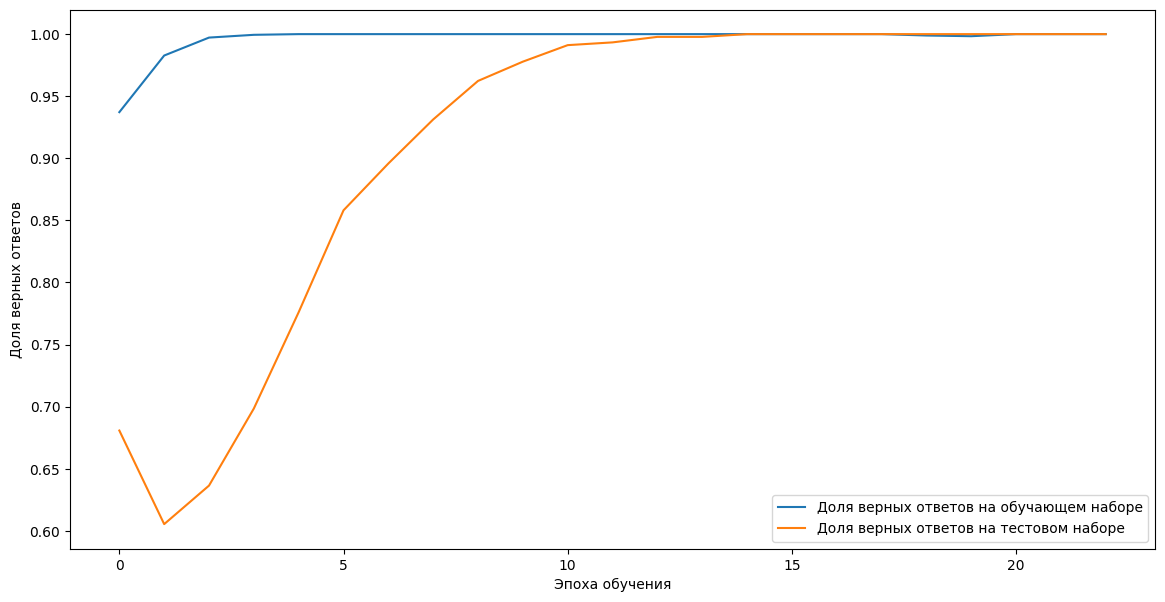

In [ ]:
# Дообучаем сеть c уменьшенным LR
model02.compile(optimizer=Adam(0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

history2 = model02.fit(
  xTrainBOW,
  yTrain,
  epochs=8,
  batch_size=128,
  validation_data=(xTestBOW, yTest)
)

plotTrainResult(
  history.history['accuracy'] + history2.history['accuracy'],
  history.history['val_accuracy'] + history2.history['val_accuracy']
)

In [ ]:
# Сохраняем полученную модель в упакованном (ZIP) виде для использования в дальнейшем
model_save(model02, SAMPLE_ID)

Модель упакована и сохранена в /content/drive/MyDrive/diplom/model_1.h5.zip


## Тестирование модели

In [ ]:
# Загружаем ранее сохраненные токенайзер и модель
used_tokenizer = load_tokenizer()
bestModel = model_restore(SAMPLE_ID)

Загружен токенайзер из файла '/content/drive/MyDrive/diplom/tokenizer.pickle'
Загружена модель из файла /content/drive/MyDrive/diplom/model_1.h5.zip


In [ ]:
# Тестируем качество распознавания на проверочной выборке
prediction = bestModel.predict(xCheckBOW, verbose = 0)
correct_predictions_count = 0
for i in range(len(prediction)):
  pi = prediction[i]
  predictedClass = np.argmax(pi)
  actualClass = np.argmax(yCheck[i])
  if predictedClass == actualClass:
    correct_predictions_count += 1

prediction_quality = round(correct_predictions_count / len(prediction) * 100, 2)
print(f"Процент распознавания на проверочной выборке: {prediction_quality}%")

Процент распознавания на проверочной выборке: 100.0%


# Проверка работы нейросети на тексте, введенном вручную

In [ ]:
# Загружаем ранее сохраненные токенайзер и модель
used_tokenizer_prod = load_tokenizer()
best_model_prod = model_restore(SAMPLE_ID)
best_model_prod.compile()

Загружен токенайзер из файла '/content/drive/MyDrive/diplom/tokenizer.pickle'
Загружена модель из файла /content/drive/MyDrive/diplom/model_1.h5.zip


In [ ]:
def human_text_probability(model, tokenizer, text: str) -> float:
  """
  Функция использует переданную модель, определяющую кем написан текст: человеком или роботом.
  Возвращает вероятность, в % того, что текст написан ЧЕЛОВЕКОМ, по версии нейросети.
  """
  word_indexes_list = tokenizer.texts_to_sequences([text])[0] # Переводим слова текста в массив в индексов: [[1133, 6, ... , 1, 11]]
  # Разрезаем массив индексов на кусочки длиной WORDS_IN_BAG со сдвигом WORDS_SHIFT
  arrays_lists: List[List[int]] = split_to_bags_of_words(word_indexes_list, WORDS_IN_BAG, WORDS_SHIFT, True)
  # Формируем массив из bag of words - каждый BOW - массив единиц и нулей длиной 20000 (MAX_WORDS_COUNT)
  bow_list: NDArray[np.int_] = tokenizer.sequences_to_matrix(arrays_lists)
  # Предсказывем
  prediction = model.predict(bow_list, verbose = 0) # На выходе - масив: [[0.37 0.63], [0.45 0.55], [0.9 0.1]...]
  # Результат считаем суммируя все нулевые элементы этих массивов. И делим на количество - получим среднюю оценку нейросети для класса "0" - машина.
  # Если это число >= 0.5, то сеть относит текст к классу "машина". Иначе - к классу "человек"
  human_text_probability_percent = round(np.sum(prediction, axis=0)[1] / len(prediction) * 100, 0)
  return human_text_probability_percent

# Загружаем ранее сохраненные токенайзер и модель
MIN_WORDS_COUNT = 100

In [ ]:
#@title Введите текст в поле ввода и нажмите кнопку "Анализировать"

text_area = Textarea(
    value='',
    placeholder='Введите сюда текст для анализа',
    layout=Layout(flex='1 1 auto', width='auto')
)

html = HTML(value='<br>')

def analize_text(btn):
  text: str = normalize_space(str(text_area.value))
  words_count = len(text.split(' '))
  if words_count < MIN_WORDS_COUNT:
    html.value = f"Текст должен содержать не менее {MIN_WORDS_COUNT} слов. В вашем тексте - {words_count} слов"
    return
  human_text_probability_percent = human_text_probability(best_model_prod, used_tokenizer_prod, text)
  who = 'человек' if human_text_probability_percent >= 50 else 'ИИ'
  probability = int(human_text_probability_percent if human_text_probability_percent >= 50 else 100 - human_text_probability_percent)
  html.value = f"Этот текст написал {who} с вероятностью {probability}%"

button = Button(
    description='Анализировать',
    tooltip=f'Определить, кем написан текст, введенный в поле: человеком или машиной. Минимальная длина текста - {MIN_WORDS_COUNT} слов',
    disabled=False,
    button_style='info', # 'success', 'info', 'warning', 'danger' or ''
)
button.on_click(analize_text)

display(text_area, button, html)

Textarea(value='', layout=Layout(flex='1 1 auto', width='auto'), placeholder='Введите сюда текст для анализа')

Button(button_style='info', description='Анализировать', style=ButtonStyle(), tooltip='Определить, кем написан…

HTML(value='<br>')